# Time Frequency Analysis of Percept recordings

## 0. Loading packages and functions, defining paths

# Importing Python and external packages


In [2]:
import os
import sys
import importlib
import json
from dataclasses import dataclass, field, fields
from itertools import compress
import csv
import pandas as pd
import numpy as np

import scipy
import matplotlib.pyplot as plt
from scipy import signal

import openpyxl
from openpyxl import Workbook, load_workbook
import xlrd

#mne
import mne_bids
import mne
from mne.time_frequency import tfr_morlet 



from importlib import reload          

# from scipy.signal import spectrogram, hanning     # hanning not found


In [3]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne_bids', mne_bids.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)

Python sys 3.10.6 | packaged by conda-forge | (main, Oct 24 2022, 16:02:16) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
mne_bids 0.11.1
mne 1.2.1
sci-py 1.9.3


In [3]:
os.getcwd()

'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\notebooks'

In [4]:
# create a path to the PyPerceive_Project folder -> project_path
# and a path to the "Data" folder and "Code" folder within the project
project_path = os.getcwd()
while project_path[-10:] != 'PyPerceive':
    project_path = os.path.dirname(project_path)

code_path = os.path.join(project_path, 'code')
sys.path.append(code_path)

# change directory to code path
os.chdir(code_path)
os.getcwd()

'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code'

## 1. Load Data using MainClass2

In [5]:
from PerceiveImport.classes import main_class as mainclass
importlib.reload(mainclass)

<module 'PerceiveImport.classes.main_class' from 'c:\\Users\\jebe12\\Research\\PyPerceive_Project\\Code\\PyPerceive\\code\\PerceiveImport\\classes\\main_class.py'>

In [6]:
from PerceiveImport.classes import main_class, modality_class, metadata_class, session_class, condition_class, task_class
import PerceiveImport.methods.load_matfile as load_matfile


In [85]:
# define an example instance and fill in the values of the dataclass PerceiveData 
# choose the values you are interested in analyzing further
importlib.reload(mainclass)
importlib.reload(session_class)
importlib.reload(task_class)
importlib.reload(condition_class)
importlib.reload(metadata_class)
importlib.reload(modality_class)
importlib.reload(load_matfile)

sub024 = mainclass.PerceiveData(
    sub = "024", 
    incl_modalities=["survey"],
    incl_session = ["postop", "fu3m", "fu12m"],
    incl_condition =['m0s0'],
    incl_task = ["rest"]
)

# Funktion:
# Eingabe nur einzelner Strings, nicht mehrfacher Str in Liste 
# bei keiner Eingabe der letzten attributes, wird default aus allen Möglichkeiten herausgegeben, jedoch funktioniert nur der 1.Input jeweils
# funktioniert nur bei vollständiger metadata Tabelle und nur, wenn filenames in perceiveFilenames == filenames in directory (nicht immer der Fall, vor allem der Anfang sub-017. sub017)
# d.h. metadata vorher überprüfen: neue xlsx mit matfiles in directory + paths (paths enthalten Info zB 3MFU) -> händisch copy paste in metadata Tabelle und vervollständigen
# gezielte Definition bereits in PerceveData Class -> 

# Pitfalls:
# bei mehreren Eingaben, funktioniert immer nur der 1.Input -> zB incl_session = ["FU3M", "PostOp", "FU12M"] -> nur FU3M funktioniert, Rest ist leer
# wenn nichts eingegeben wurde, funktioniert immer nur der 1.Input der Default Liste! -> zB default Liste ["PostOp", "FU3M", ] -> nur PostOp funktioniert, Rest ist leer
# missing function: if one attribute is left out, the connection to the next Class is missing ...  
# missing function: can´t select multiple inputs simultaneously, optimal would be: input List -> outcome: concatenated dataframes of multiple DF
# load mne raw: wenn man eine Liste mit paths lädt, kann man einen einzelnen path nicht einer metadata Tabelle zuordnen, weil mit os.walk wird eine andere Reihenfolge gelistet als in der metadata Tabelle

# neue Ziele: 
# matpath_list bestenfalls in zugehöriger Reihe in DataFrame als neues column hinzufügen -> sodass nur 1 DF weitergegeben wird
# self.data ist nur von taskClass abrufbar, optimal wäre es auch von Main, modality, session und condition class self.data abrufen zu können, und raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_field

LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1C2C. Making it a MISC channel.
  data = read_raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3, n_times=5313
    Range : 0 ... 5312 =      0.000 ...    21.248 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_8.mat


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B1C. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1C. Making it a MISC channel.
  data = read_raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021092106385396_run-LMTD20210921064900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_field

    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021092106385396_run-LMTD20210921065100_2.mat
Creating RawArray with float64 data, n_channels=3, n_times=5250
    Range : 0 ... 5249 =      0.000 ...    20.996 secs
Ready.
LOADED sub024_ses-2021092106385396_run-LMTD20210921065200_3.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021092106385396_run-LMTD20210921065400_4.mat


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1C2C. Making it a MISC channel.
  data = read_raw

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B1C. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021092106385396_run-LMTD20210921065800_5.mat
Creating RawArray with float64 data, n_channels=3, n_times=5188
    Range : 0 ... 5187 =      0.000 ...    20.748 secs
Ready.
LOADED sub024_ses-2021092106385396_run-LMTD20210921065800_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1C2C. Making it a MISC channel.
  data = read_raw

    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071200.mat
Creating RawArray with float64 data, n_channels=3, n_times=5125
    Range : 0 ... 5124 =      0.000 ...    20.496 secs
Ready.
LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071400.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1C. Making it a MISC channel.
  data = read_raw

LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071500.mat
Creating RawArray with float64 data, n_channels=3, n_times=5188
    Range : 0 ... 5187 =      0.000 ...    20.748 secs
Ready.
LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071700.mat


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1C. Making it a MISC channel.
  data = read_raw

In [9]:
sub021RingR = sub021.survey.fu3m.m0s0.rest.data['RestBSSuRingR']


In [11]:
# Beispiel: ich möchte von sub 017, alle Survey files vom M0S0 für jeden Timepoint (session) 
# erstelle je 1 DF für jede session
data = {}

sub = '024'
modality = 'survey'
cond = 'm0s0'

session = ['fu3m']

data[sub] = {}
for s in session:
    mod = getattr(sub021, modality)
    data[sub][s] = getattr(mod, s)




In [22]:
data['021']['fu3m'] # hier soll metadata Tabelle angezeigt werden -> davon kann ich dann im nächsten Schritt mit mne data laden

sessionClass(sub='021', modality='survey', session='fu3m', metaClass=MetadataClass(sub='021', incl_modalities=['survey'], incl_session=['postop', 'fu3m', 'fu12m'], incl_condition=['m0s0'], incl_task=['rest'], orig_meta_table=                                               report  \
0   sub-021_Report_Json_Session_Report_20210512T13...   
1   sub-021_Report_Json_Session_Report_20210512T13...   
2   sub-021_Report_Json_Session_Report_20210512T13...   
3   sub-021_Report_Json_Session_Report_20210512T13...   
4   sub-021_Report_Json_Session_Report_20210512T13...   
5   sub-021_Report_Json_Session_Report_20210512T13...   
6   sub-021_Report_Json_Session_Report_20210512T13...   
7   sub-021_Report_Json_Session_Report_20210512T13...   
8   sub-021_Report_Json_Session_Report_20210512T13...   
9   sub-021_Report_Json_Session_Report_20210512T13...   
10  sub-021_Report_Json_Session_Report_20210512T13...   
11  sub-021_Report_Json_Session_Report_20210806T17...   
12  sub-021_Report_Json_Session_Re

In [21]:
# load the chosen perceive .mat files with MNE
# e.g.: from subject 021 all Survey files from FU3M 
# store each loaded raw file in a dictionary with keys named raw_idx -> idx unfortunately doesn´t match with DF because paths are in different order (initially looped through folders...)

# sub = "021"
# raw_perceive_path = find_folders.get_onedrive_path("raw_perceive", sub)

# raw_021 = {}
# count = -1
# path_list = []


# for file in data['021']['FU3M'].metaClass.metadata["perceiveFilename"]:

#     # make a list with all paths to the selected perceive files
#     path_list.append(os.path.join(raw_perceive_path, file))
    

# # load each path with mne and store in a dictionary raw_021{}
# for path in path_list:

#     count +=1

#     raw_021["raw_{0}".format(count)] = mne.io.read_raw_fieldtrip(
#         path,
#         info={},
#         data_name='data'
#         )

In [25]:
sub021RingR.info.keys()


dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

### Define variables 

In [26]:



ch_names = sub021RingR.ch_names
n_chan = len(ch_names)
n_time_samps = sub021RingR.n_times #nsamples
time_secs = sub021RingR.times #timepoints set to zero
ch_trials = sub021RingR._data
sampling_freq = sub021RingR.info['sfreq']
time_duration = (n_time_samps/sampling_freq).astype(float)



print(
      f'The data object has:\n\t{n_time_samps} time samples,'
      f'\n\tand a sample frequency of {sampling_freq} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{ch_names}.'
)

The data object has:
	5288 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.152 seconds.
	6 channels were labeled as 
['LFP_Stn_R_03', 'LFP_Stn_R_13', 'LFP_Stn_R_02', 'LFP_Stn_R_12', 'LFP_Stn_R_01', 'LFP_Stn_R_23'].


## 2. MNE basics

In [86]:

sub024 = mainclass.PerceiveData(
    sub = "024", 
    incl_modalities=["survey"],
    incl_session = ["postop", "fu3m", "fu12m"],
    incl_condition =["m0s0"],
    incl_task = ["rest"]
    )

Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618062900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_field

    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063200_4.mat
Creating RawArray with float64 data, n_channels=3, n_times=5187
    Range : 0 ... 5186 =      0.000 ...    20.744 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1C2C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021061806255999_run-LMTD20210618063300_5.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063400_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = read_raw_field

    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.
LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_7.mat
Creating RawArray with float64 data, n_channels=3, n_times=5313
    Range : 0 ... 5312 =      0.000 ...    21.248 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1C2C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021061806255999_run-LMTD20210618063500_8.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_field

LOADED sub024_ses-2021092106385396_run-LMTD20210921064900_1.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B1C. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A1C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021092106385396_run-LMTD20210921065100_2.mat
Creating RawArray with float64 data, n_channels=3, n_times=5250
    Range : 0 ... 5249 =      0.000 ...    20.996 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_1C2C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021092106385396_run-LMTD20210921065200_3.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = read_raw_field

LOADED sub024_ses-2021092106385396_run-LMTD20210921065400_4.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B1C. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A1C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021092106385396_run-LMTD20210921065800_5.mat
Creating RawArray with float64 data, n_channels=3, n_times=5188
    Range : 0 ... 5187 =      0.000 ...    20.748 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1A2A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1B2B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_1C2C. Making it a MISC channel.
  data = read_raw

LOADED sub024_ses-2021092106385396_run-LMTD20210921065800_6.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_L_02. Making it a MISC channel.
  data = read_raw_field

LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071200.mat
Creating RawArray with float64 data, n_channels=3, n_times=5125
    Range : 0 ... 5124 =      0.000 ...    20.496 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1C. Making it a MISC channel.
  data = read_raw

LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071400.mat
Creating RawArray with float64 data, n_channels=6, n_times=5288
    Range : 0 ... 5287 =      0.000 ...    21.148 secs
Ready.


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_03. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_13. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_R_02. Making it a MISC channel.
  data = read_raw_field

LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071500.mat
Creating RawArray with float64 data, n_channels=3, n_times=5188
    Range : 0 ... 5187 =      0.000 ...    20.748 secs
Ready.
LOADED sub-20210615PStn_ses-2022072210000082_run-LMTD20220609071700.mat


c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: The supplied FieldTrip structure does not have an elec or grad field. No channel locations will extracted and the kind of channel might be inaccurate.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1A. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1B. Making it a MISC channel.
  data = read_raw_fieldtrip(
c:\Users\jebe12\Research\PyPerceive_Project\Code\PyPerceive\code\PerceiveImport\methods\load_matfile.py:31: RuntimeWarning: Cannot guess the correct type of channel LFP_Stn_TWO_1C. Making it a MISC channel.
  data = read_raw

In [11]:
# to get information on mne function type 
# mne.<function_name>?

mne.preprocessing?

Type:        module
String form: <module 'mne.preprocessing' from 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\preprocessing\\__init__.py'>
File:        c:\users\jebe12\anaconda3\envs\pyperceive_dev\lib\site-packages\mne\preprocessing\__init__.py
Docstring:   Preprocessing with artifact detection, SSP, and ICA.


In [ ]:
# mne uses multiple submodules

# e.g. mne.preprocessing, 
# mne.viz for visualisation
# mne.io for reading and writing data
# mne.stats for statistics


# you can import submodules directly 
# e.g. from mne.preprocessing import eog

In [87]:
raw = sub024.survey.fu3m.m0s0.rest.data['RestBSSuRingR']

In [30]:
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

In [46]:
raw.info["bads"]

[]

In [88]:
raw.ch_names
n_chan = len(raw.ch_names)
raw.n_times #umber of samples
raw.times #timepoints set to zero
raw._data # channel trials 
raw.info['sfreq'] # sampling frequency
time_duration = (n_time_samps/sampling_freq).astype(float)



print(
      f'The data object has:\n\t{raw.n_times} time samples,'
      f'\n\tand a sample frequency of {raw.info["sfreq"]} Hz' 
      f'\n\twith a recording duration of {time_duration} seconds.' 
      f'\n\t{n_chan} channels were labeled as \n{raw.ch_names}.'
)

The data object has:
	5288 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 21.152 seconds.
	6 channels were labeled as 
['LFP_Stn_R_03', 'LFP_Stn_R_13', 'LFP_Stn_R_02', 'LFP_Stn_R_12', 'LFP_Stn_R_01', 'LFP_Stn_R_23'].


In [101]:
# convert data to pd.DataFrame
DF = raw.to_data_frame()
DF


,time,LFP_Stn_R_03,LFP_Stn_R_13,LFP_Stn_R_02,LFP_Stn_R_12,LFP_Stn_R_01,LFP_Stn_R_23
0,0.000,4.380876,-4.326490,4.156216,-1.360106,8.197560,-1.010971
1,0.004,1.010971,-5.578895,1.909613,-3.060238,5.465040,-0.898641
2,0.008,0.449321,-4.895765,0.000000,-3.626949,3.415650,-1.235632
3,0.012,-1.909613,-2.618665,-2.358933,-2.040159,-0.113855,-0.224660
4,0.016,-5.728838,-2.618665,-5.841168,-2.606869,-3.301795,-1.010971
...,...,...,...,...,...,...,...
5283,21.132,-2.583594,-1.252405,-2.920584,-2.040159,-1.252405,0.786311
5284,21.136,-5.504178,0.455420,-4.942527,1.020079,-6.717445,1.347962
5285,21.140,-5.391848,2.846375,-6.739809,1.246764,-10.133095,1.010971
5286,21.144,-2.021943,3.643360,-6.515149,1.360106,-6.717445,2.583594


In [56]:
# convert data to NumPy array
raw.get_data().shape


(6, 5288)

## 3. Exploring and plotting data

### Plotting based on matplotlib and mne

In [148]:
# Matplotlib: set the style
plt.style.use('seaborn-whitegrid')

# "classic"

In [114]:
# used in Python Notebooks
%matplotlib inline 

# %matplotlib inline will lead to static images of your plot embedded within the notebook

In [94]:
sessionclass = getattr(sub024.survey, 'fu3m') # this gets the attribute fu3m from the modality class with modality=survey

In [157]:
# the attribute from .data from the task class is a dictionary with keys named after each task. 
data = sessionclass.m0s0.rest.data
data["RestBSSuRingR"].ch_names


['LFP_Stn_R_03',
 'LFP_Stn_R_13',
 'LFP_Stn_R_02',
 'LFP_Stn_R_12',
 'LFP_Stn_R_01',
 'LFP_Stn_R_23']

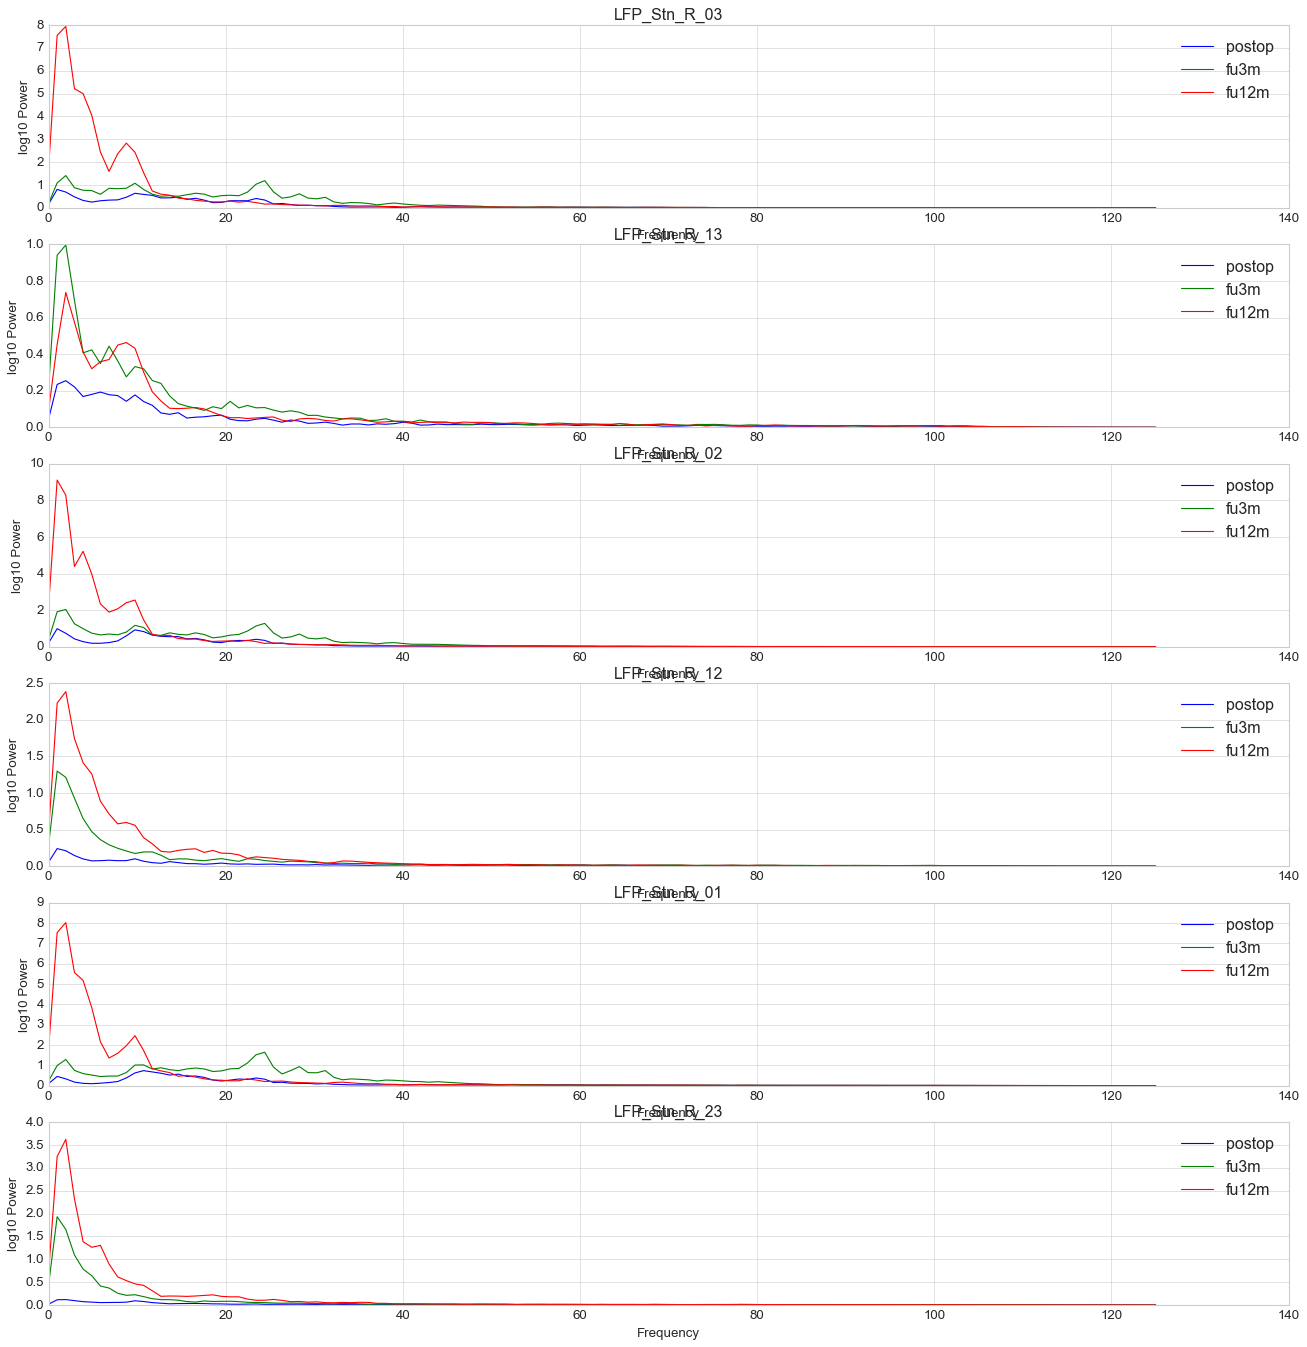

In [161]:

time_points = ['postop', 'fu3m', 'fu12m']
task_contact = 'RestBSSuRingR'

# create grid for plots: 
# fig = plt.figure() -> figure is an instance of a single container containing all objects representing axes, graphics, text and labels
# axes = plt.axes() -> axes is a box which will contain the plot
fig, axes = plt.subplots(len(data[task_contact].ch_names), 1, figsize=(20, 20)) # rows as many as channels, 1 column


for t, tp in enumerate(time_points):
    temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
    temp_data = temp_data.m0s0.rest.data[task_contact] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

    # sample frequency: 250 Hz
    fs = temp_data.info['sfreq']

    # channel names 
    ch_names = temp_data.info.ch_names


    for i, ch in enumerate(ch_names):

        # .get_data() gets time series data as an array, [i, :] only gets the row with index i, e.g. index=0 gives time series data of 1st channel "LFP_Stn_R_03"
        f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)

        # the title of each plot is set to the channel e.g. "LFP_Stn_R_03"
        axes[i].set_title(ch) 
        axes[i].plot(f, px, label=tp)

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlabel="Frequency", ylabel="log10 Power")
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")
    # ax.axis([10, 40, -10, 4]) # [xmin, xmax, ymin, ymax]


plt.show() 


    
# for adding subplots use Figure.add_subplot()

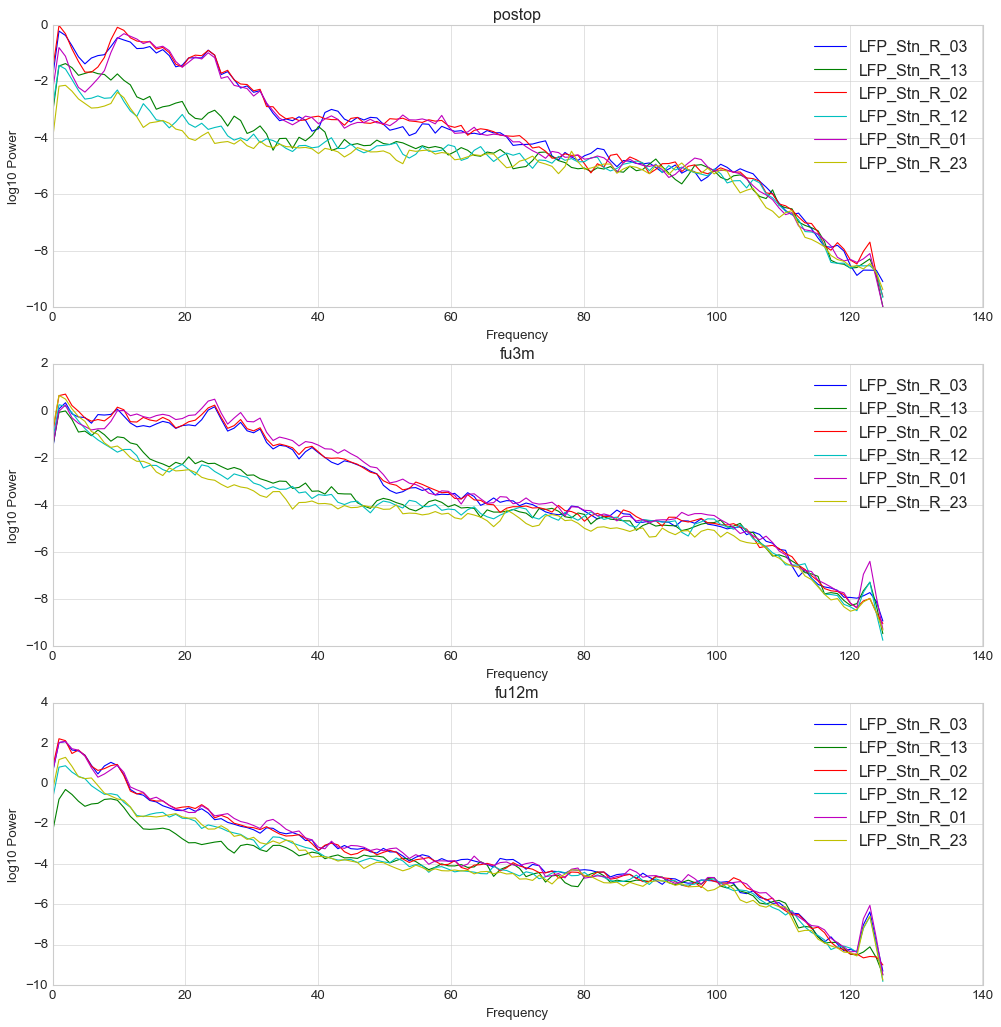

In [156]:
time_points = ['postop', 'fu3m', 'fu12m']

# set layout for figures: using the object-oriented interface
fig, axes = plt.subplots(len(time_points), 1, figsize=(15, 15)) # subplot(rows, columns, panel number)

for t, tp in enumerate(time_points):

    # apply loop over channels
    temp_data = getattr(sub024.survey, tp) # gets attribute e.g. of tp "postop" from modality_class with modality set to survey
    temp_data = temp_data.m0s0.rest.data['RestBSSuRingR'] # gets the mne loaded data from the perceive .mat BSSu, m0s0 file with task "RestBSSuRingR"

    # sample frequency: 250 Hz
    fs = temp_data.info['sfreq'] 

    # the title of each plot is set to the timepoint e.g. "postop"
    axes[t].set_title(tp)  


    for i, ch in enumerate(temp_data.info.ch_names):

        # .get_data() gets time series data as an array, [i, :] only gets the row with index i, e.g. index=0 gives time series data of 1st channel "LFP_Stn_R_03"
        f, px = signal.welch(temp_data.get_data()[i, :], fs)  # Returns: f=array of sample frequencies, px= psd or power spectrum of x (amplitude)

        # .plot() method for creating the plot, axes[0] refers to the first plot, the plot is set on the appropriate object axes[t]
        axes[t].plot(f, np.log(px), label=ch) 


        # calculate and plot power spectrum per channel in same plot of timepoint

for ax in axes: 
    ax.legend() # shows legend for each axes[t]
    ax.set(xlabel="Frequency", ylabel="log10 Power")
    # ax.set(xlim=(10, 40), ylim=(-10, 4), xlabel="Frequency", ylabel="log10 Power")
    # ax.axis([10, 40, -10, 4]) # [xmin, xmax, ymin, ymax]


plt.show() # always needed to visualize the plot, in a .py file, use plt.show() only once and at the very end of the file -> it will plot all figures of the script

In [118]:
# saving figures with savefig(), will be saved in the cwd
sub = '024'
fig.savefig(f'sub{sub}_plotPsdBSSu_m0s0.png')

# to view the .png code:
# from IPython.display import Image
# Image("sub024_plotPsdBSSu_m0s0.png")

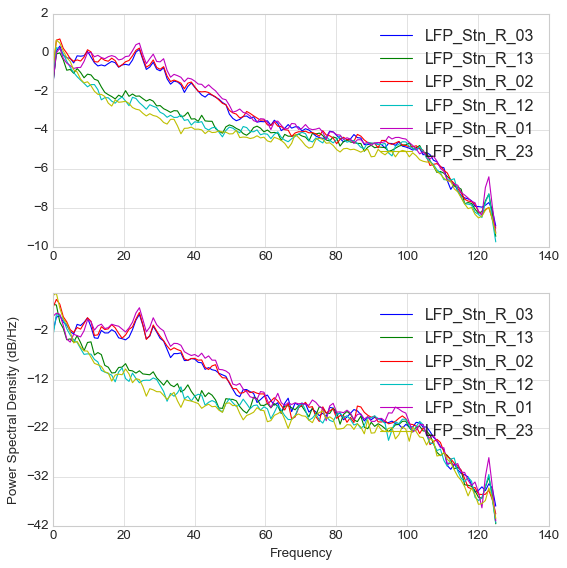

In [150]:
# plot Power Spectra with matplotlib function

# plot info
fs = raw.info['sfreq']


fig, axes = plt.subplots(2, 1, figsize=(8, 8))

for i, ch in enumerate(raw.info.ch_names):

    f, px = signal.welch(raw.get_data()[i, :], fs) 

    axes[0].plot(f, np.log(px), label=ch)


    # built-in matplotlib function (power in dB)
    axes[1].psd(
        raw.get_data()[i, :], Fs=fs,
        label=ch,
    )

axes[0].legend()
axes[1].legend()

plt.show()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\63740021.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=ch)


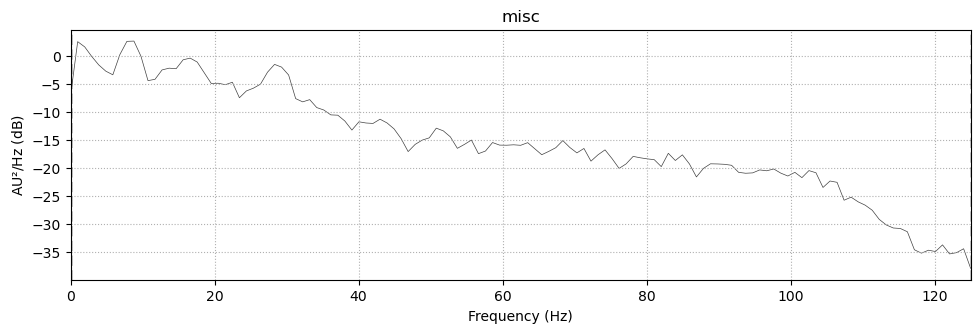

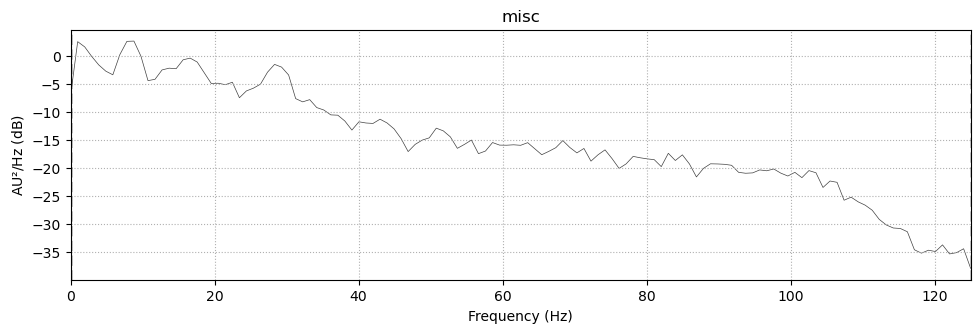

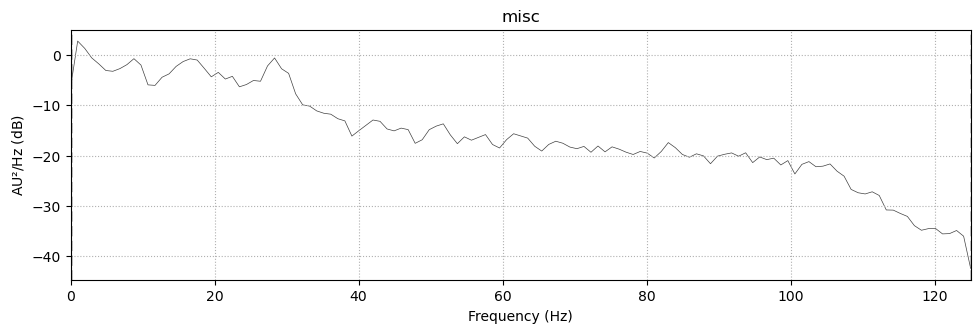

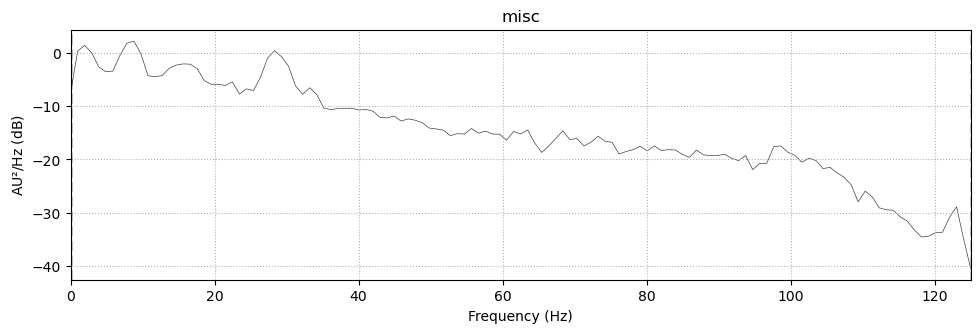

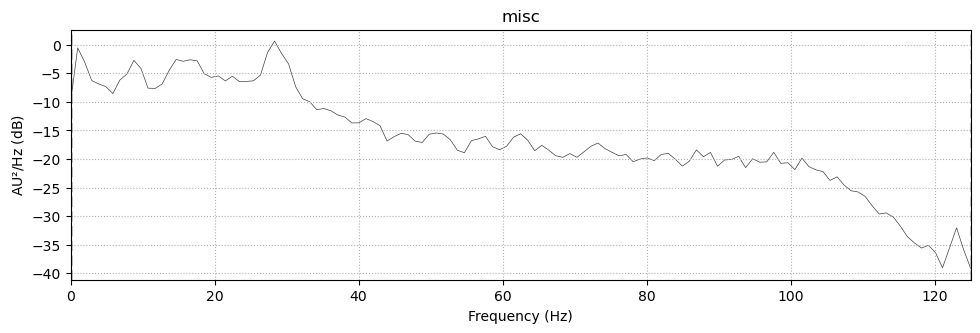

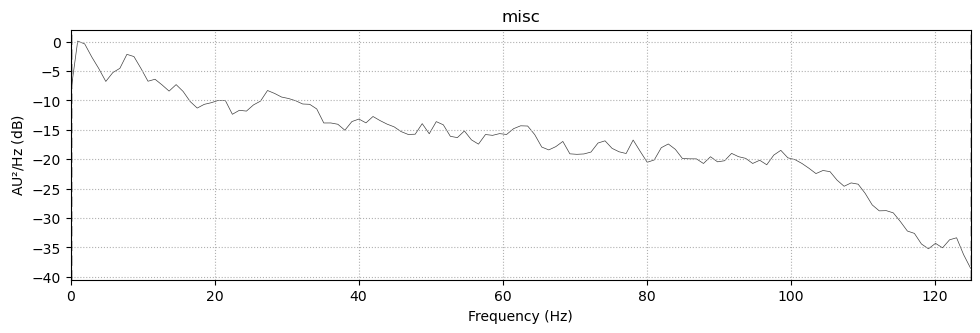

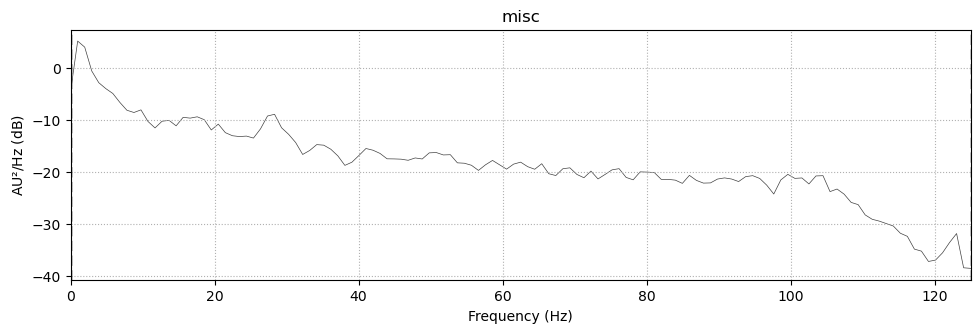

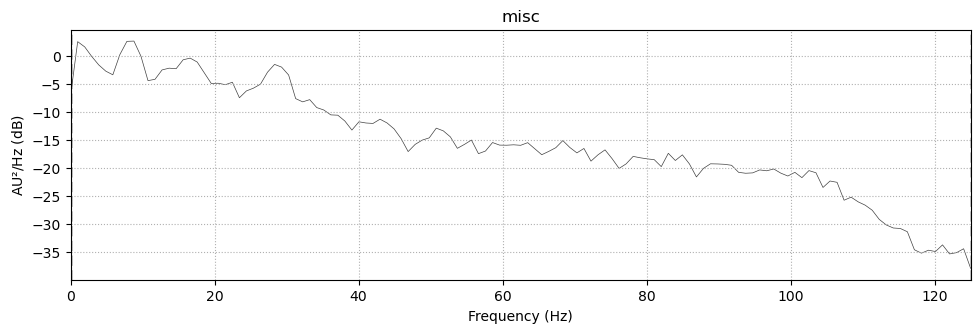

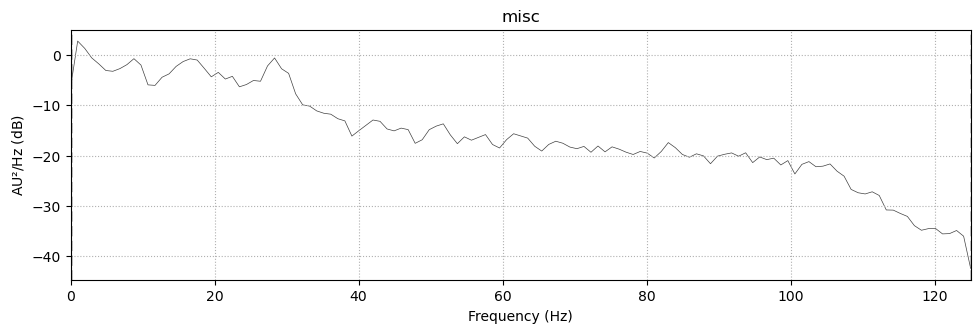

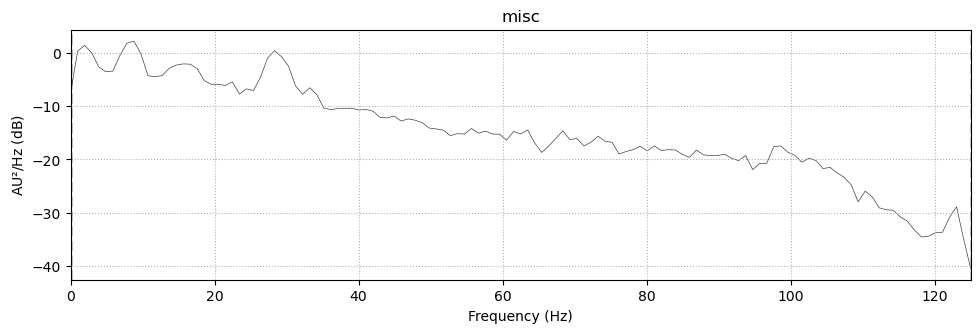

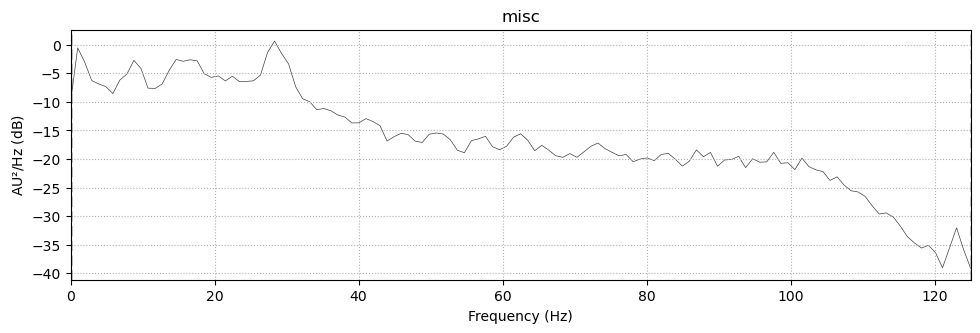

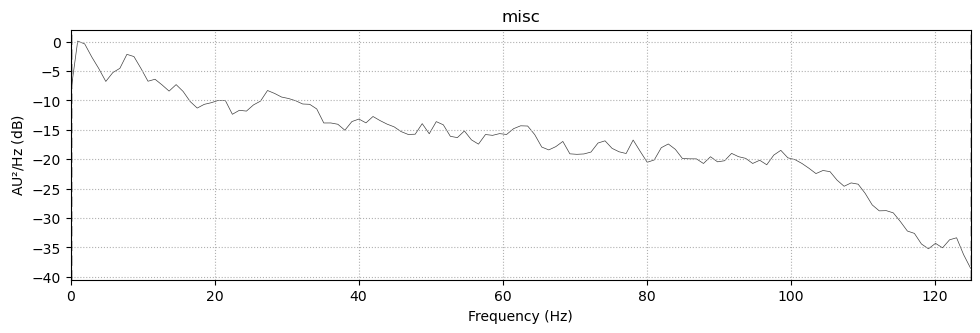

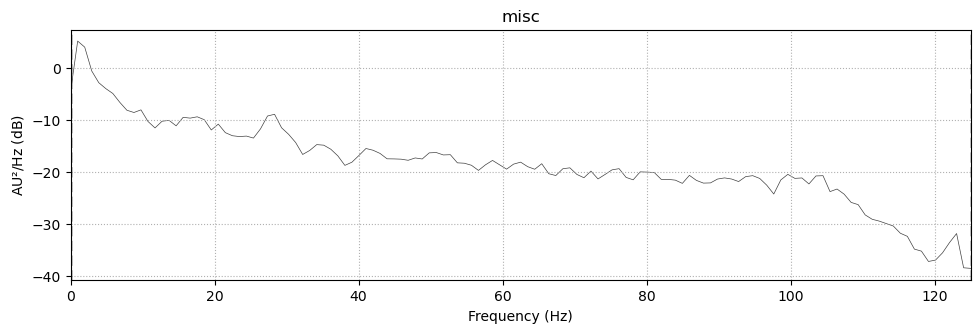

In [62]:
# mne built-in methods
for ch in raw.info.ch_names:
    raw.plot_psd(picks=ch)

plt.show()

Using matplotlib as 2D backend.


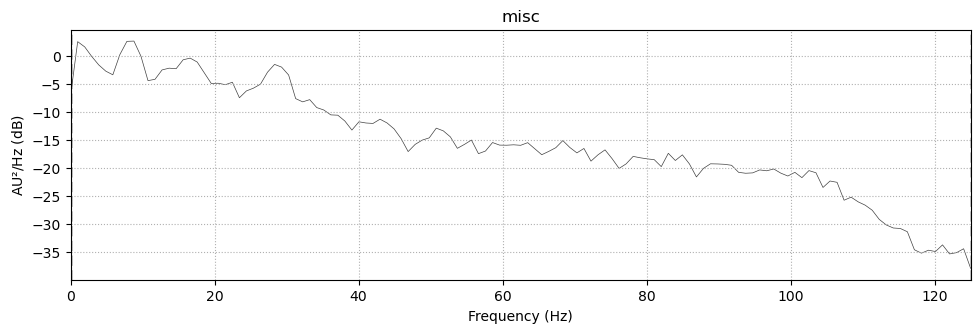

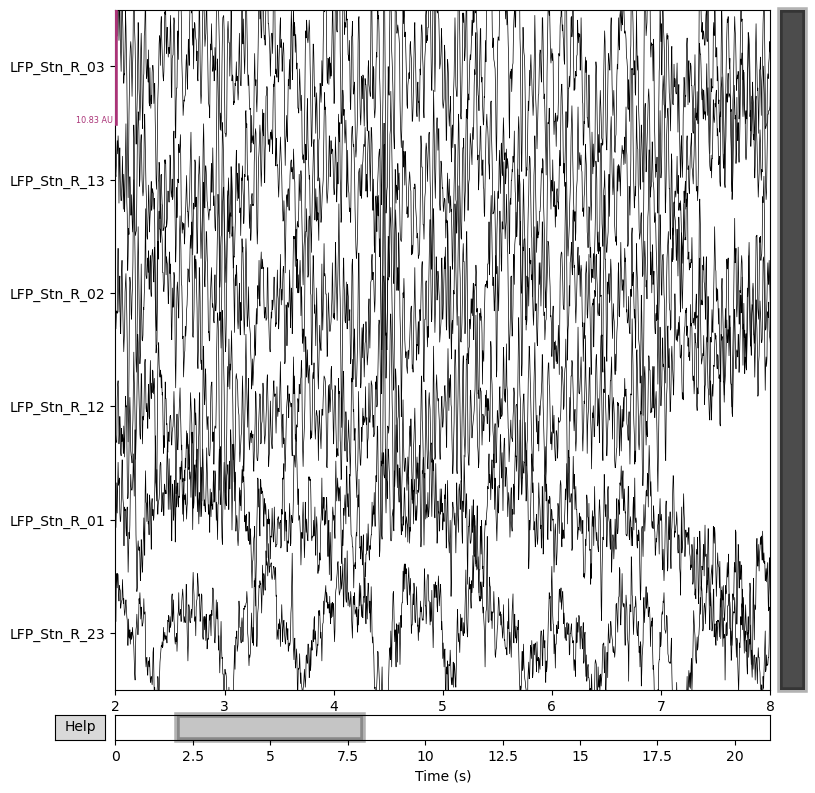

Figure(800x800)


In [38]:
fig = raw.plot(start=2, duration=6)
print(fig)


Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\2976338963.py:14: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  spectrum.plot(picks = chs_to_plot, average=False, color='b')


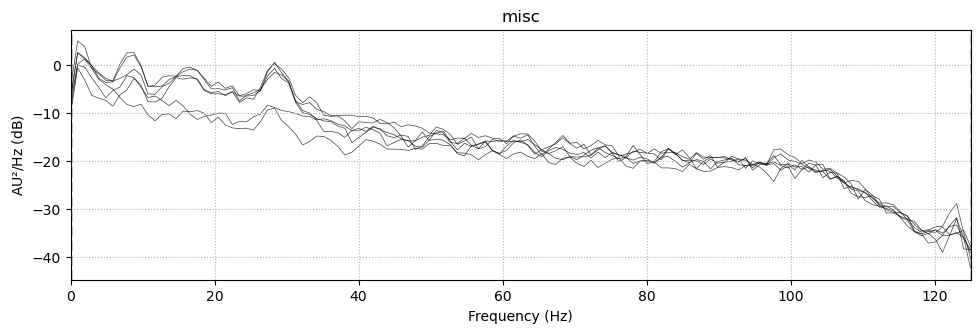

In [39]:
chs_to_plot = [
    'LFP_Stn_R_03',	
    'LFP_Stn_R_13',	
    'LFP_Stn_R_02',	
    'LFP_Stn_R_12',	
    'LFP_Stn_R_01',	
    'LFP_Stn_R_23'
    ]

# to plot spectral power create object spectrum
spectrum = raw.compute_psd(picks = chs_to_plot )

# spectrum has a built-in plot() method 
spectrum.plot(picks = chs_to_plot, average=False, color='b')

### Matplotlib Playground

In [40]:
# extract a selection of raw[]

start_stop_seconds = np.array([11, 13])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)

channel_index = 0
raw_selection = raw[channel_index, start_sample:stop_sample]

print(f'We here selected the timepoints from {start_sample} until {stop_sample}' 
      f'\nand selected the channel {raw.ch_names[channel_index]}')

# print(raw_selection)

We here selected the timepoints from 2750 until 3250
and selected the channel LFP_Stn_R_03


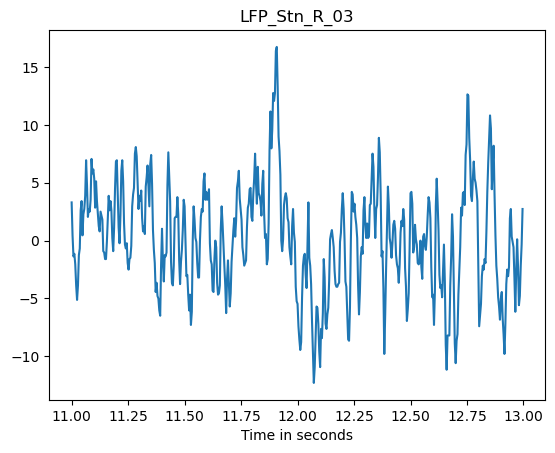

In [42]:
# plot the selected 2 arrays

x = raw_selection[1]        # time in seconds
y = raw_selection[0].T      # data from ch_trials[channel_index]

plt.plot(x, y)

plt.title(str(raw.ch_names[channel_index]))
plt.xlabel("Time in seconds")
# plt.ylabel() ???

plt.show()

<Figure size 640x480 with 0 Axes>

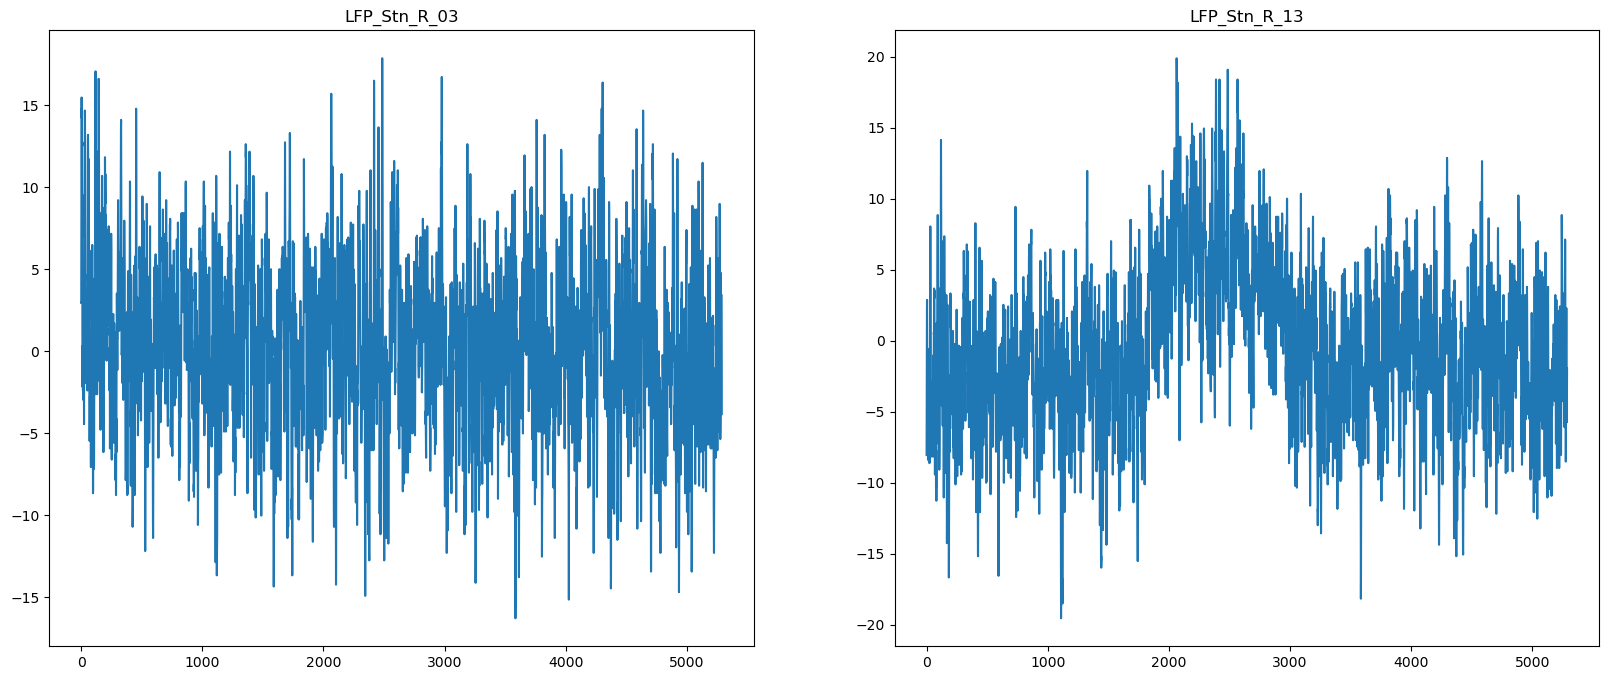

In [43]:
# plotting first and second trials from first 2 channels 

plt.suptitle("Raw data of channels left and right")

plt.figure(figsize= (20, 8))

# plot raw data of channel LFP_R_1A1B_STN
plt.subplot(1,2,1)
plt.plot(raw._data[0])
plt.title(str(raw.ch_names[0]))

# plot raw data of channel LFP_R_1B1C_STN
plt.subplot(1,2,2)
plt.plot(raw._data[1])
plt.title(str(raw.ch_names[1]))

plt.show()


In [44]:
# from Varvara

#Make some nice plots of the data

#channels to plot:
chs_to_plot = [
    'LFP_Stn_R_03',	
    'LFP_Stn_R_13',	
    'LFP_Stn_R_02',	
    'LFP_Stn_R_12',	
    'LFP_Stn_R_01',	
    'LFP_Stn_R_23'
    ]

plot_times = raw.times #timepoints set to zero
xticks = np.linspace(0, plot_times[-1], 5) #make 5 x-axis ticks, dividing the seconds by 5

fig, axes = plt.subplots(
    1, len(chs_to_plot), figsize=(18, 6)
) #define n of subplots and size

# axes = axes.flatten()
ax_c = 0 

for i, name in enumerate(chs_to_plot):

    
    if name in chs_to_plot:

        if name[-3:] == 'STN': # last three letters 
            axes[ax_c].psd(raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(
                f'PSD {name}',
                fontsize=16, color='r'
            )

        else:
            
            axes[ax_c].plot(plot_times, raw._data[i, :]) # e.g. raw._data[1,:] will output index 1 of all raw._data -> data from 2nd channel 
            axes[ax_c].set_title(name, fontsize=16, color='r')
            axes[ax_c].set_xticks(xticks)
            axes[ax_c].set_xticklabels(np.around(xticks / 60, 1))
                
        ax_c += 1 # count for-loop

In [45]:
raw._data

array([[ 2.96023003,  2.96023003,  8.19756008, ..., -3.87107004,
        -1.48011501,  3.41565003],
       [-8.04263409, -5.17026477,  0.45957909, ..., -5.74473864,
        -2.41279023, -1.95321114],
       [ 4.36600136,  3.10215886,  6.3192125 , ...,  2.527685  ,
         4.59579091,  7.12347591],
       [-4.21263504, -4.32649004, -1.59397002, ..., -2.04939002,
         0.91084001,  3.52950503],
       [ 9.00290141,  8.31037054,  7.73326147, ...,  3.5780762 ,
         2.77012351,  2.77012351],
       [-1.02935271, -1.60121533,  0.91498019, ..., -4.57490095,
        -2.8593131 , -3.77429329]])

In [75]:
raw.tmin

0.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.024 (s)


C:\Users\jebe12\AppData\Local\Temp\ipykernel_4548\2182701887.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')


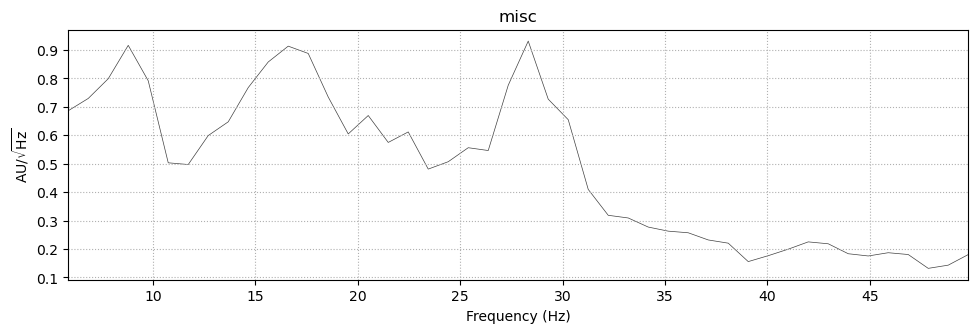

In [46]:
#raw.compute_psd(picks = chs_to_plot ).plot(fmin = 5, fmax = 50, picks = 1, tmin = 0, tmax = 10, dB = False, estimate = 'amplitude')
raw.plot_psd(fmin = 5, fmax = 50, picks = 1, tmin = raw.tmin, tmax = raw.tmax,  dB = False, estimate = 'amplitude')


# time: tmin - tmax (continuos data)

In [47]:
chan = 1 # set channel we want

start_time = int((1000 / 1000) * raw.info['sfreq']) # 250
end_time   = int((10000 / 1000) * raw.info['sfreq']) # 2500

raw._data[chan, start_time:end_time]


array([-5.51494909, -7.46816023, -7.46816023, ..., -0.22978955,
        1.03405295,  1.83831636])

In [48]:
mydat = raw.get_data(picks=['LFP_Stn_R_03'], start=1, stop=201)
print(mydat.shape)

(1, 200)


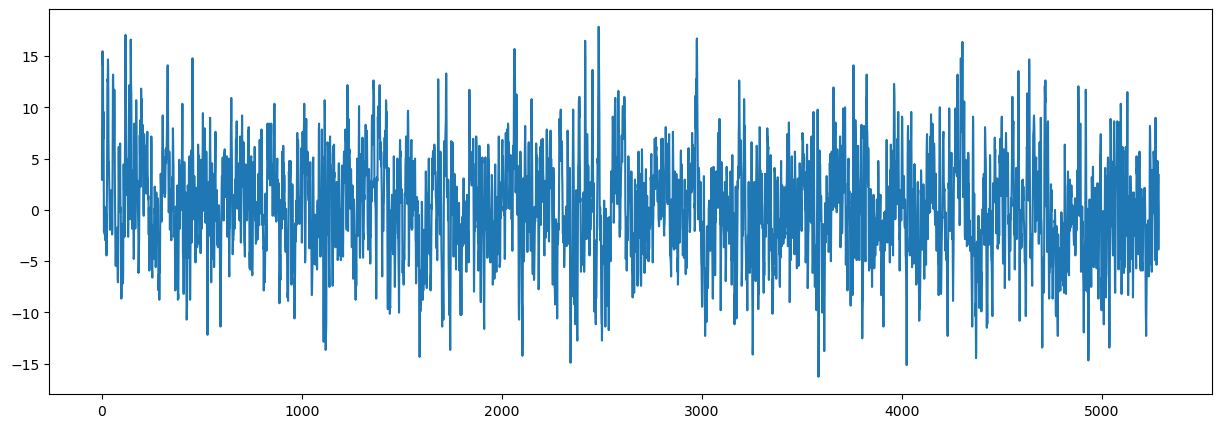

In [51]:
fig, ax = plt.subplots(figsize=[15, 5])

ax.plot(raw.get_data(picks=['LFP_Stn_R_03'],start=1, stop=20000).T)
plt.show()

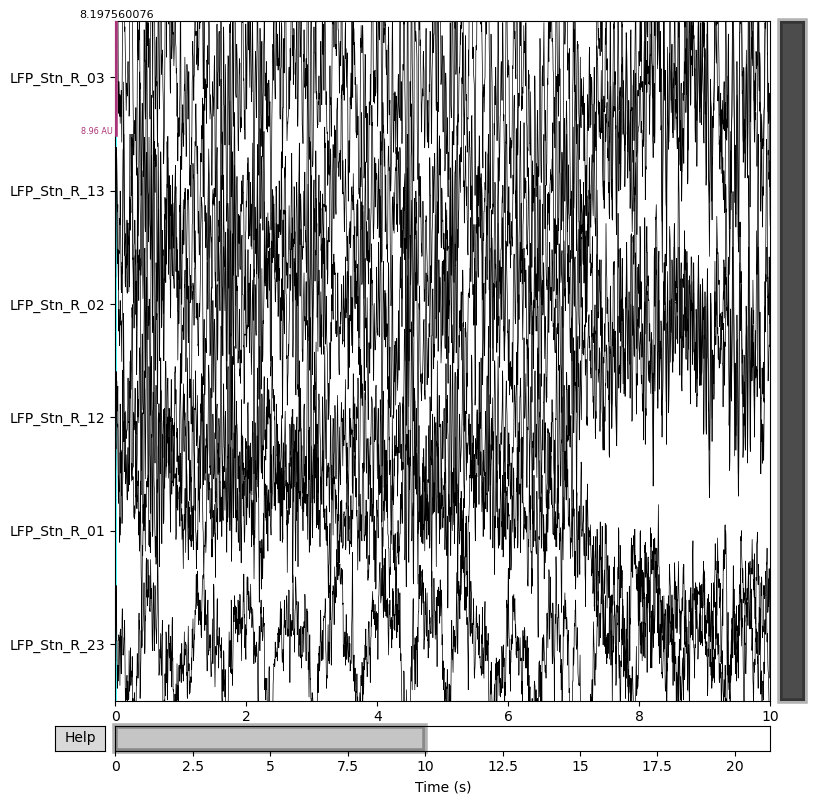

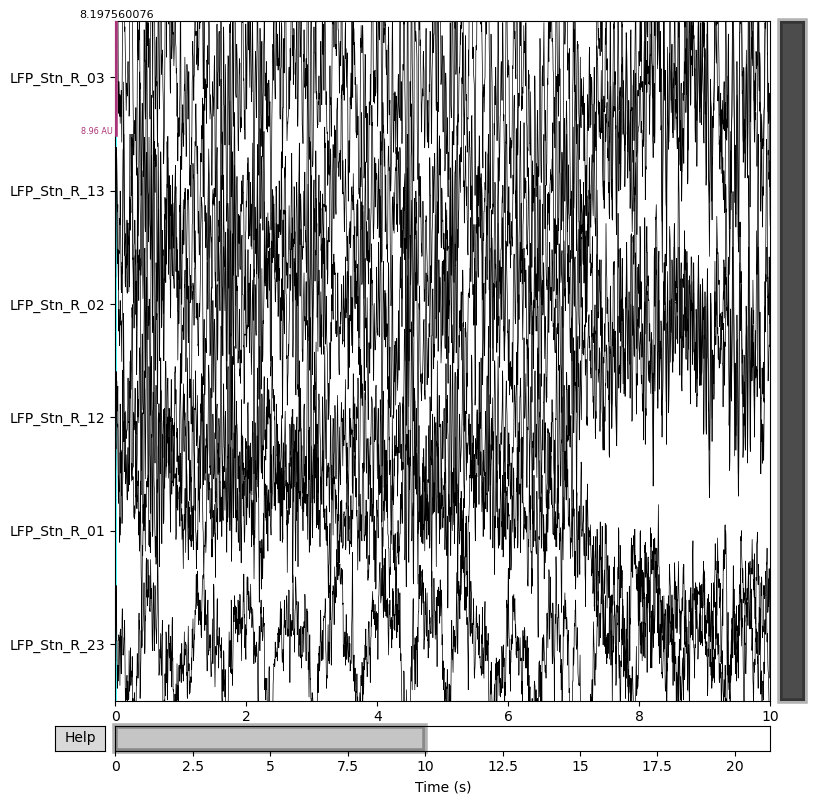

In [53]:
raw.plot(raw.get_data(picks='LFP_Stn_R_03'))

In [96]:
raw.info['bads'] = [
    'LFP_R_1A1B_STN', 
    'LFP_R_1B1C_STN', 
    'LFP_R_1A1C_STN',
    'LFP_R_2A2B_STN', 
    'LFP_R_2B2C_STN', 
    'LFP_R_2A2C_STN',] 

picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads')

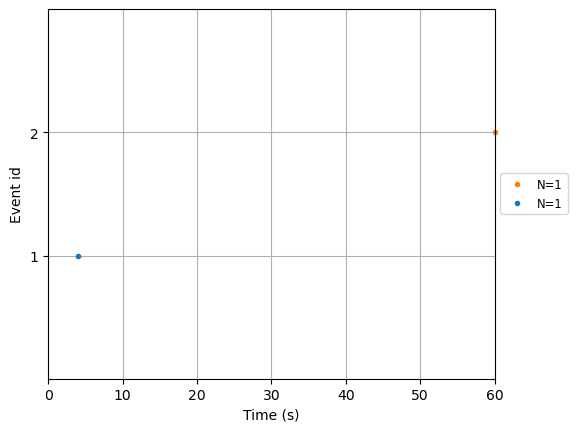

Not setting metadata
2 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 2 events and 2501 original time points ...
1 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\1477881095.py:9: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks = 0)


IndexError: list index out of range

In [97]:
#events = mne.find_events(raw, stim_channel='LFP_R_13_STN') -> no stim channel in BrainSenseSurvey
trial_onsets = np.array([
       [ 1000 ,      0 ,    1],
       [ 15000 ,      0 ,    2 ]]) #we need the samples

event_dict = {'NoStim':1,'Threshold':2}
fig = mne.viz.plot_events(trial_onsets, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)
epochs = mne.Epochs(raw,events=trial_onsets,event_id = event_dict, tmin=0, tmax=10, baseline = None, preload = True)
epochs.plot_image(picks = 0)

In [99]:
# nostim_ep = epochs['NoStim']
# stim_ep = epochs['Threshold']
# stim_ep.plot_image(picks = 1)

In [100]:
M = 200
NFFT = M
win = hanning(M)
overlap = 0.25
overlap_samples = int(round(M*overlap)) # overlap in samples
t, f, S = spectrogram(mydat,window=win,nperseg=M,noverlap=overlap_samples,nfft=NFFT)

# Compute average spectrum
avg_S = np.mean(S,axis=1)

NameError: name 'hanning' is not defined

In [108]:
vars(tfr_morlet)

{'__wrapped__': <function mne.time_frequency.tfr.tfr_morlet(inst, freqs, n_cycles, use_fft=False, return_itc=True, decim=1, n_jobs=None, picks=None, zero_mean=True, average=True, output='power', verbose=None)>,
 '__qualname__': 'tfr_morlet',
 '__globals__': {'__name__': 'mne.time_frequency.tfr',
  '__doc__': 'A module which implements the time-frequency estimation.\n\nMorlet code inspired by Matlab code from Sheraz Khan & Brainstorm & SPM\n',
  '__package__': 'mne.time_frequency',
  '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1e124cdfb80>,
  '__spec__': ModuleSpec(name='mne.time_frequency.tfr', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001E124CDFB80>, origin='c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py'),
  '__file__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev\\lib\\site-packages\\mne\\time_frequency\\tfr.py',
  '__cached__': 'c:\\Users\\jebe12\\anaconda3\\envs\\pyPerceive_dev

In [107]:
freqs = np.arange(1, 125)
D = tfr_morlet(epochs, freqs=freqs, n_cycles=6, return_itc=False, average=True, picks = 1)

In [110]:
spectrogram(
    mydat,
    fs=125.0, 
#             window=('hanning', 0.25), 
    nperseg=1, 
    noverlap=0.25, 
    nfft=None, 
    detrend='constant', 
    return_onesided=True, 
    scaling='density', 
    axis=- 1, 
    mode='psd')

(array([0.]),
 array([0.004, 0.012, 0.02 , 0.028, 0.036, 0.044, 0.052, 0.06 , 0.068,
        0.076, 0.084, 0.092, 0.1  , 0.108, 0.116, 0.124, 0.132, 0.14 ,
        0.148, 0.156, 0.164, 0.172, 0.18 , 0.188, 0.196, 0.204, 0.212,
        0.22 , 0.228, 0.236, 0.244, 0.252, 0.26 , 0.268, 0.276, 0.284,
        0.292, 0.3  , 0.308, 0.316, 0.324, 0.332, 0.34 , 0.348, 0.356,
        0.364, 0.372, 0.38 , 0.388, 0.396, 0.404, 0.412, 0.42 , 0.428,
        0.436, 0.444, 0.452, 0.46 , 0.468, 0.476, 0.484, 0.492, 0.5  ,
        0.508, 0.516, 0.524, 0.532, 0.54 , 0.548, 0.556, 0.564, 0.572,
        0.58 , 0.588, 0.596, 0.604, 0.612, 0.62 , 0.628, 0.636, 0.644,
        0.652, 0.66 , 0.668, 0.676, 0.684, 0.692, 0.7  , 0.708, 0.716,
        0.724, 0.732, 0.74 , 0.748, 0.756, 0.764, 0.772, 0.78 , 0.788,
        0.796, 0.804, 0.812, 0.82 , 0.828, 0.836, 0.844, 0.852, 0.86 ,
        0.868, 0.876, 0.884, 0.892, 0.9  , 0.908, 0.916, 0.924, 0.932,
        0.94 , 0.948, 0.956, 0.964, 0.972, 0.98 , 0.988, 0.996,

In [54]:
raw = raw.filter(l_freq=90, h_freq=5, picks=['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN'])

ValueError: picks (['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN']) could not be interpreted as channel names (no channel "['LFP_R_1A1B_STN', 'LFP_R_1B1C_STN']"), channel types (no type "LFP_R_1A1B_STN"), or a generic type (just "all" or "data")

## 4. Preprocessing

In [119]:
# detecting power line noise
fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
fig.show()

# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(x=freqs[idx], y=psds[idx] + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

Effective window size : 1.024 (s)
Aggregating Welch estimates (median) before plotting...


C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = raw.compute_psd(picks=chs_to_plot, tmax=np.inf, fmax=125.0, average=None).plot(picks=chs_to_plot)
c:\Users\jebe12\anaconda3\envs\pyPerceive_dev\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
C:\Users\jebe12\AppData\Local\Temp\ipykernel_15384\3965450946.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [122]:
#from mne.preprocessing import create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog

# detect ecg artifacts

ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine='mean')

ValueError: Unable to generate artificial ECG channel